In [130]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping

# On va chercher les données dans le fichier CSV
data = pd.read_csv('./data/train.csv')

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
labels = ['toxic']

# On va séparer les données en deux parties : les commentaires et les labels
X = data['comment_text']
y = data[labels]

# On va séparer les données en deux parties : une pour l'entraînement et une pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Déterminons le meilleur max_len basé sur la longueur des commentaires
X_train.str.split().apply(len).describe()

# 75% des commentaires ont moins de 75 mots

count    127656.000000
mean         67.483785
std          99.710637
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: comment_text, dtype: float64

In [131]:
max_len = 100

# Ici le tokenizer va transformer les commentaires en séquences de nombres.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# On va ajouter des 0 pour que toutes les séquences aient la même longueur.
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# On va utiliser un algorithme de sous-échantillonnage pour équilibrer les classes.
X_resampled_list = []
y_resampled_list = []

for label in labels:
  X_res, y_res = RandomUnderSampler().fit_resample(X_train_pad, y_train[label])
  X_resampled_list.append(X_res)
  y_resampled_list.append(y_res)
  
X_resampled = np.concatenate(X_resampled_list, axis=0)
y_resampled = np.concatenate(y_resampled_list, axis=0)

In [132]:
embedding_dim = 100

# Charger les embeddings GloVe
embeddings_index = {}
with open('./data/weights/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Créer une matrice d'embeddings
embeddings_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [136]:
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D, Bidirectional, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam


model = Sequential()
model.add(Embedding(len(word_index) + 1,
                    embedding_dim,
                    weights=[embeddings_matrix],
                    input_length=max_len,
                    input_shape=(max_len,),
                    trainable=False))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))

# Ajuster le taux d'apprentissage
optimizer = Adam(learning_rate=0.0001)

from tensorflow.keras.metrics import Metric
import tensorflow.keras.backend as K

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = self.add_weight(name='precision', initializer='zeros')
        self.recall = self.add_weight(name='recall', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.round(y_pred)
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        self.precision.assign(true_positives / (predicted_positives + K.epsilon()))
        self.recall.assign(true_positives / (possible_positives + K.epsilon()))

    def result(self):
        return 2 * ((self.precision * self.recall) / (self.precision + self.recall + K.epsilon()))

    def reset_states(self):
        self.precision.assign(0)
        self.recall.assign(0)

# Compiler le modèle avec la métrique personnalisée
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/opt/anaconda3/envs/ai/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/opt/anaconda3/envs/ai/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)        │ (None, 100, 100)       │    18,319,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,340,001 (69.96 MB)

 Trainable params: 20,201 (78.91 KB)

 Non-trainable params: 18,319,800 (69.88 MB)

Epoch 1/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7234 - loss: 0.5375 - val_accuracy: 0.8850 - val_loss: 0.3307
Epoch 2/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8189 - loss: 0.4099 - val_accuracy: 0.8533 - val_loss: 0.4145
Epoch 3/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8228 - loss: 0.4088 - val_accuracy: 0.7338 - val_loss: 0.5631
Epoch 4/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.7910 - loss: 0.4480 - val_accuracy: 0.8680 - val_loss: 0.3529
Epoch 5/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8470 - loss: 0.3689 - val_accuracy: 0.8871 - val_loss: 0.2888
Epoch 6/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8135 - loss: 0.4099 - val_accuracy: 0.8246 - val_loss: 0.4569
Epoch 7/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.7749 - loss: 0.4654 - val_accuracy: 0.8119 - val_loss: 0.3885
Epoch 8/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.8106 - loss: 0.4184 - val_accu

KeyError: 'f1_score'

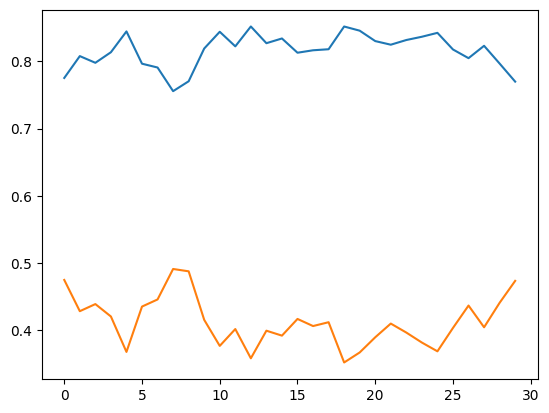

In [ ]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import Callback

# Ensure that the validation data is correctly formatted
y_test_array = y_test.to_numpy()

# Entraîner le modèle avec le callback
history = model.fit(X_resampled, y_resampled, epochs=30, batch_size=128, validation_data=(X_test_pad, y_test_array))


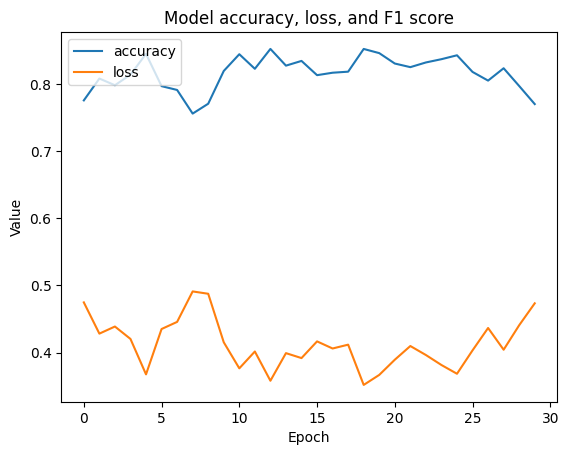

In [138]:
# Afficher les résultats de l'entraînement (accuracy et loss)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.title('Model accuracy, loss, and F1 score')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [139]:
# On affiche les matrices de confusion pour chaque label.
for label in labels:
    y_pred = model.predict(X_test_pad)
    y_pred = (y_pred > 0.5).astype(int)
    print(confusion_matrix(y_test[label], y_pred))
    print(classification_report(y_test[label], y_pred))

998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
[[24521  4338]
 [  872  2184]]
              precision    recall  f1-score   support

           0       0.97      0.85      0.90     28859
           1       0.33      0.71      0.46      3056

    accuracy                           0.84     31915
   macro avg       0.65      0.78      0.68     31915
weighted avg       0.91      0.84      0.86     31915



0.45604510336187093
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


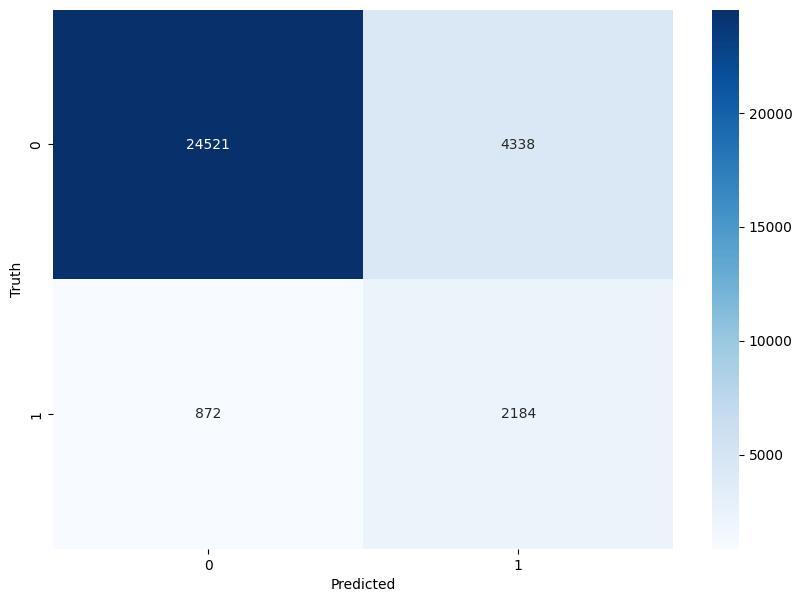

In [140]:
# Plot confusion matrix

for label in labels:
    # F1 score
    print(f1_score(y_test[label], y_pred))

    y_pred = model.predict(X_test_pad)
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(y_test[label], y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()